<a href="https://colab.research.google.com/github/clar04/cancer-classification/blob/main/Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
falgunipatel19_biomedical_text_publication_classification_path = kagglehub.dataset_download('falgunipatel19/biomedical-text-publication-classification')

print('Data source import complete.')


Data source import complete.


# Pyspark Installation

In [3]:
!pip install pyspark
!pip install tqdm

# Inisialisasion Library

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import col,lit
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Creating SparkSession

In [5]:
spark = SparkSession.builder.appName("Medical Analysis").getOrCreate()

data_schema = StructType([
    StructField("id",IntegerType(), nullable=True),
    StructField("labels",StringType(), nullable=True),
    StructField("Text", StringType(),nullable=True),
])

# Load CSV Data

In [6]:
data = spark.read.csv("/kaggle/input/biomedical-text-publication-classification/alldata_1_for_kaggle.csv", schema=data_schema)
data.show(5)

+----+--------------+--------------------+
|  id|        labels|                Text|
+----+--------------+--------------------+
|NULL|             0|                   a|
|   0|Thyroid_Cancer|Thyroid surgery i...|
|   1|Thyroid_Cancer|""" The adopted s...|
|   2|Thyroid_Cancer|coronary arteryby...|
|   3|Thyroid_Cancer| Solitary plasmac...|
+----+--------------+--------------------+
only showing top 5 rows



In [7]:
data = data.withColumnRenamed("0", "labels").withColumnRenamed("a", "text")

# Data Exploration

## Duplicate Count
Menghitung jumlah baris yang memiliki duplikat dan menghitung banyak kemunculannya

In [8]:
duplicate_count = data.groupBy(data.columns).count().filter(col("count") > 1).selectExpr("sum(count - 1)").first()[0]

print(f"Jumlah baris duplikat: {duplicate_count}")

Jumlah baris duplikat: 29


## Remove Duplicates
Menghapus baris yang duplikat dan menghitung sisa duplikat

In [9]:
data = data.dropDuplicates()
duplicate_count = data.groupBy(data.columns).count().filter(col("count") > 1).selectExpr("sum(count - 1)").first()[0]
print(f"Jumlah baris duplikat: {duplicate_count}")

Jumlah baris duplikat: None


## Filter Labels
Memfilter data kemudian menghilangkan baris yang memiliki nilai `null` pada kolom `labels`

In [10]:
data = data.filter((col("labels").isNotNull()) & (col("labels") != "0"))

Menghitung kemunculan masing-masing tabel

In [11]:
labels = data.groupBy(data.labels).count()
labels.show()

+--------------+-----+
|        labels|count|
+--------------+-----+
|Thyroid_Cancer| 2810|
|   Lung_Cancer| 2180|
|  Colon_Cancer| 2580|
+--------------+-----+



In [12]:
data.show(5)

+---+------------+--------------------+
| id|      labels|                Text|
+---+------------+--------------------+
|313|Colon_Cancer|"""  curcumin is ...|
|376|Colon_Cancer|"""as metastasis ...|
|544| Lung_Cancer|"""Statistical an...|
|669| Lung_Cancer|"""Twenty-one day...|
|713| Lung_Cancer|"""Thus mathemati...|
+---+------------+--------------------+
only showing top 5 rows



# Data Preparation and Splitting
## Split Data

In [13]:
from pyspark.sql.functions import lit

def stratified_split(data, label_col, train_size=0.8, seed=42):
    # Calculate fractions for test set
    test_size = 1 - train_size
    fractions = data.select(label_col).distinct().withColumn("fraction", lit(test_size)).rdd.collectAsMap()

    # Split the data: 'train_data' will now be larger
    test_data = data.sampleBy(label_col, fractions, seed)
    train_data = data.subtract(test_data)  # Remaining data is used for training

    return train_data, test_data

# Melakukan stratified split dengan training size lebih besar
train_data, test_data = stratified_split(data, "labels", train_size=0.8, seed=42)

# Memeriksa jumlah data
print("Jumlah data di training set: ", train_data.count())
print("Jumlah data di test set: ", test_data.count())

# Menampilkan beberapa baris dari training dan test set
print("Training Data Sample:")
train_data.show(5)

print("Test Data Sample:")
test_data.show(5)


Jumlah data di training set:  6051
Jumlah data di test set:  1519
Training Data Sample:
+----+--------------+--------------------+
|  id|        labels|                Text|
+----+--------------+--------------------+
| 376|  Colon_Cancer|"""as metastasis ...|
| 544|   Lung_Cancer|"""Statistical an...|
| 669|   Lung_Cancer|"""Twenty-one day...|
| 713|   Lung_Cancer|"""Thus mathemati...|
|1018|Thyroid_Cancer|"""Lung adenocarc...|
+----+--------------+--------------------+
only showing top 5 rows

Test Data Sample:
+----+--------------+--------------------+
|  id|        labels|                Text|
+----+--------------+--------------------+
|1139|Thyroid_Cancer|ConcernExpression...|
|2870|  Colon_Cancer|    gastrointesti...|
|3654|   Lung_Cancer|""" Despite previ...|
|2166|   Lung_Cancer|"""(a) shows a fr...|
| 526|  Colon_Cancer|preoperative hear...|
+----+--------------+--------------------+
only showing top 5 rows



In [14]:
# Menggunakan fungsi stratified_split yang sudah diperbarui
train_data, test_data = stratified_split(data, "labels", train_size=0.8, seed=42)

# Mengonversi kolom teks menjadi list untuk digunakan oleh Tokenizer
X_train = train_data.select("text").rdd.flatMap(lambda x: x).collect()
X_test = test_data.select("text").rdd.flatMap(lambda x: x).collect()
y_train = train_data.select("labels").rdd.flatMap(lambda x: x).collect()
y_test = test_data.select("labels").rdd.flatMap(lambda x: x).collect()



In [15]:
from pyspark.ml.feature import StringIndexer

# Pastikan untuk menggunakan nama kolom yang konsisten, misalnya 'labels'
indexer = StringIndexer(inputCol="labels", outputCol="labelIndex")

# Melatih StringIndexer dengan data training
indexer_model = indexer.fit(train_data)

# Mendapatkan label asli setelah diindeks
label_mapping = indexer_model.labels

# Menampilkan label dan mapping ke label yang diindeks
for index, label in enumerate(label_mapping):
    print(f"Label {index}: {label}")


Label 0: Thyroid_Cancer
Label 1: Colon_Cancer
Label 2: Lung_Cancer


## Tokenization

In [16]:
# Menggunakan Tokenizer dari Keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Contoh keluaran pertama dari X_train_seq
print(X_train_seq[0])

[210, 179, 4, 1650, 4, 6, 463, 4843, 21, 34391, 16504, 117167, 4161, 117168, 10399, 117169, 4161, 72, 117170, 117171, 117172, 117173, 117174, 1, 20329, 2, 179, 1444, 2, 259, 21999, 157, 52487, 126, 21999, 3944, 7350, 16817, 2, 179, 9072, 15435, 6098, 201, 3, 119, 422, 18783, 3944, 7350, 29891, 2, 259, 9072, 15435, 6098, 201, 3, 119, 422, 18783, 3944, 7350, 1325, 1587, 34391, 16504, 52488, 482, 2, 179, 1444, 2, 259, 21999, 157, 6957, 1998, 52487, 126, 21999, 3944, 7350, 34391, 117175, 7694, 117176, 11212, 52488, 117177, 117178, 6, 117179, 6, 117180, 14, 117181, 72, 117182, 72, 210, 179, 4, 1650, 4, 6, 463, 4843, 21, 1492, 3944, 372, 504, 1778, 870, 69, 337, 455, 1082, 1082, 11337, 2, 3944, 259, 3944, 7350, 24, 11, 28, 415, 191, 1, 196, 263, 14255, 471, 792, 466, 5957, 1, 1974, 2, 34, 55, 26, 2418, 27, 117183, 117184, 117185, 32, 20, 210, 179, 4, 1650, 22, 117186, 1628, 609, 32, 20, 210, 179, 4, 6, 2137, 117187, 171, 3102, 117188, 7484, 142, 239, 43025, 3, 299, 30, 509, 2126, 3, 63, 32, 

## Random Forest Classification

In [17]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# Membuat DataFrame untuk Random Forest
# Menggunakan StringIndexer untuk mengubah label string menjadi label numerik
indexer = StringIndexer(inputCol="labels", outputCol="label")
train_data_indexed = indexer.fit(train_data).transform(train_data)
test_data_indexed = indexer.fit(test_data).transform(test_data)

# Menyiapkan fitur untuk Random Forest
from pyspark.ml.feature import HashingTF, IDF, Tokenizer as SparkTokenizer

# Tokenisasi kolom teks (dengan kolom yang benar)
tokenizer = SparkTokenizer(inputCol="Text", outputCol="words")  # Ganti "text" dengan "Text"
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Membuat pipeline untuk Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf, rf])

# Melatih model Random Forest
rf_model = pipeline.fit(train_data_indexed)

# Melakukan prediksi
predictions_rf = rf_model.transform(test_data_indexed)

# Menampilkan hasil prediksi
predictions_rf.select("Text", "labels", "prediction").show(5)  # Ganti "text" dengan "Text"


+--------------------+--------------+----------+
|                Text|        labels|prediction|
+--------------------+--------------+----------+
|ConcernExpression...|Thyroid_Cancer|       2.0|
|    gastrointesti...|  Colon_Cancer|       1.0|
|""" Despite previ...|   Lung_Cancer|       2.0|
|"""(a) shows a fr...|   Lung_Cancer|       2.0|
|preoperative hear...|  Colon_Cancer|       0.0|
+--------------------+--------------+----------+
only showing top 5 rows



## Logistic Regression

In [18]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, Tokenizer, HashingTF, IDF
from pyspark.ml import Pipeline
from tqdm import tqdm
import time

# Mengatur log level
spark.sparkContext.setLogLevel("ERROR")

# StringIndexer
indexer = StringIndexer(inputCol="labels", outputCol="label")

# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Feature pipeline
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="features")

# Pipeline
pipeline_lr = Pipeline(stages=[tokenizer, hashing_tf, idf, indexer, lr])

# Parameter Grid for Tuning (using only regParam)
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Optional caching to speed up repeated data access
train_data.cache()

# Cross-Validation with reduced folds
crossval = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2,
                          parallelism=4)  # Paralel evaluasi

# Menghitung jumlah evaluasi yang akan dilakukan
num_models = len(paramGrid) * crossval.getNumFolds()

# Membuat progress bar
with tqdm(total=num_models, desc="Evaluating parameters") as pbar:
    start_time = time.time()

    # Cross-validation dan logging progres
    lr_model = crossval.fit(train_data)

    # Update progress bar secara manual setiap kali model diuji
    for i in range(num_models):
        time.sleep(0.1)  # Simulasi waktu training
        pbar.update(1)

    end_time = time.time()

# Hasil akhir
print(f"Cross-validation completed in {end_time - start_time:.2f} seconds")

# Get the best model from cross-validation
best_lr_model = lr_model.bestModel

# Make predictions using the best model
predictions_lr = best_lr_model.transform(test_data)

# Evaluate the model
accuracy = evaluator.evaluate(predictions_lr)
print("Accuracy:", accuracy)


Evaluating parameters: 100%|██████████| 4/4 [25:51<00:00, 387.95s/it]


Cross-validation completed in 1551.78 seconds
Accuracy: 0.9973666886109283


## Decision Tree Classifier

In [19]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
# Membuat DataFrame
# Menggunakan StringIndexer untuk mengubah label string menjadi label numerik
indexer = StringIndexer(inputCol="labels", outputCol="label")
train_data_indexed = indexer.fit(train_data).transform(train_data)
test_data_indexed = indexer.fit(test_data).transform(test_data)

# Menyiapkan fitur
from pyspark.ml.feature import HashingTF, IDF, Tokenizer as SparkTokenizer

# Tokenisasi kolom teks (dengan kolom yang benar)
tokenizer = SparkTokenizer(inputCol="Text", outputCol="words")  # Ganti "text" dengan "Text"
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Pipeline
pipeline_dt = Pipeline(stages=[tokenizer, hashing_tf, idf, indexer, dt])

# Melatih model Decision Tree
dt_model = pipeline_dt.fit(train_data)

# Melakukan prediksi
predictions_dt = dt_model.transform(test_data)


# Model Evaluation

In [20]:
from pyspark.mllib.evaluation import MulticlassMetrics

def evaluate_model(predictions):
    prediction_and_labels = predictions.select("prediction", "label").rdd
    metrics = MulticlassMetrics(prediction_and_labels)

    # Confusion Matrix
    confusion_matrix = metrics.confusionMatrix().toArray()
    print("Matriks Kebingungan:")
    print(confusion_matrix)

    # Metrics
    accuracy = metrics.accuracy
    print(f"Akurasi: {accuracy}")

    # Mendapatkan label unik dari data
    labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

    for label in labels:
        precision = metrics.precision(label)
        recall = metrics.recall(label)
        f1_score = metrics.fMeasure(label)
        print(f"Label: {label} - Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

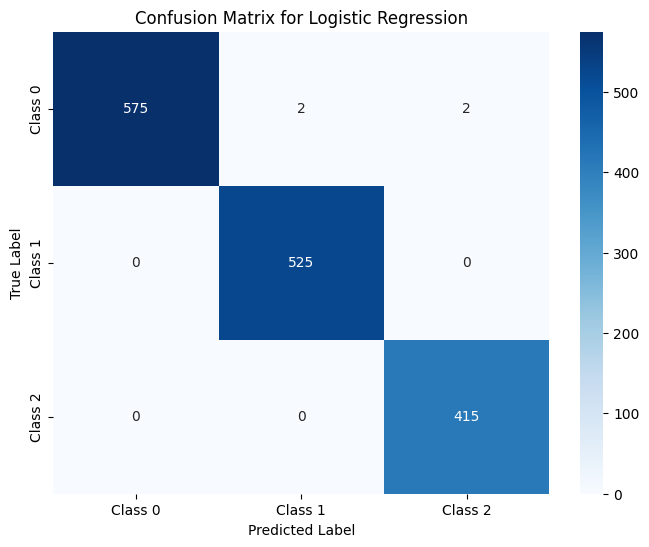

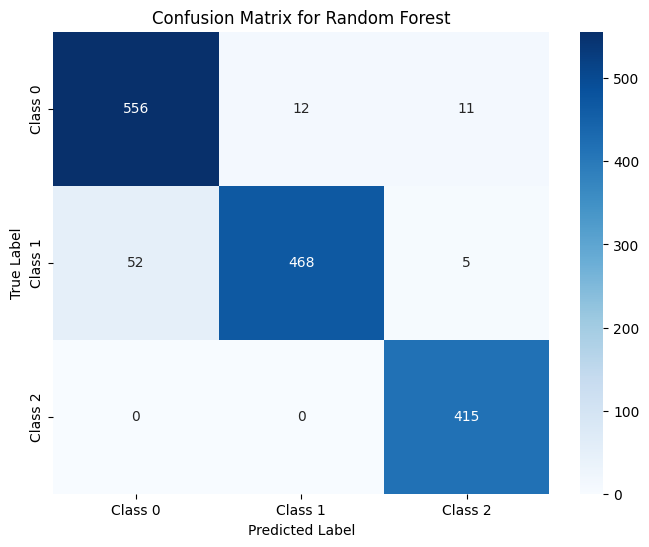

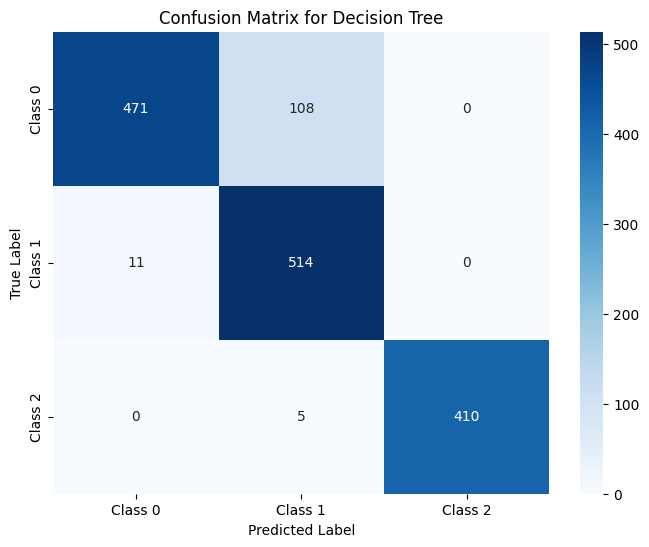

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, model_name):
    y_true = predictions.select("label").rdd.flatMap(lambda x: x).collect()
    y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Class 0", "Class 1", "Class 2"],
                yticklabels=["Class 0", "Class 1", "Class 2"])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Visualizing confusion matrices for each model
plot_confusion_matrix(predictions_lr, "Logistic Regression")
plot_confusion_matrix(predictions_rf, "Random Forest")
plot_confusion_matrix(predictions_dt, "Decision Tree")


In [22]:
print("Logistic Regression Model Evaluation")
evaluate_model(predictions_lr)

print("Random Forest Model Evaluation")
evaluate_model(predictions_rf)

print("Decision Tree Model Evaluation")
evaluate_model(predictions_dt)

Logistic Regression Model Evaluation


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Matriks Kebingungan:
[[575.   2.   2.]
 [  0. 525.   0.]
 [  0.   0. 415.]]
Akurasi: 0.9973666886109283
Label: 0.0 - Precision: 1.0, Recall: 0.9930915371329879, F1 Score: 0.9965337954939341
Label: 1.0 - Precision: 0.9962049335863378, Recall: 1.0, F1 Score: 0.9980988593155894
Label: 2.0 - Precision: 0.9952038369304557, Recall: 1.0, F1 Score: 0.9975961538461539
Random Forest Model Evaluation
Matriks Kebingungan:
[[556.  12.  11.]
 [ 52. 468.   5.]
 [  0.   0. 415.]]
Akurasi: 0.9473337722185649
Label: 0.0 - Precision: 0.9144736842105263, Recall: 0.9602763385146805, F1 Score: 0.93681550126369
Label: 1.0 - Precision: 0.975, Recall: 0.8914285714285715, F1 Score: 0.9313432835820894
Label: 2.0 - Precision: 0.962877030162413, Recall: 1.0, F1 Score: 0.9810874704491725
Decision Tree Model Evaluation
Matriks Kebingungan:
[[471. 108.   0.]
 [ 11. 514.   0.]
 [  0.   5. 410.]]
Akurasi: 0.9183673469387755
Label: 0.0 - Precision: 0.9771784232365145, Recall: 0.8134715025906736, F1 Score: 0.887841658812

## Distribusi Prediksi

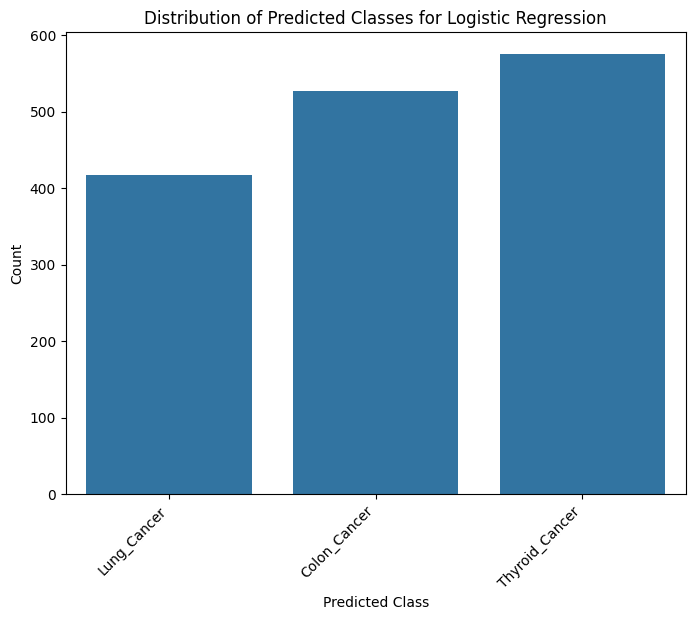

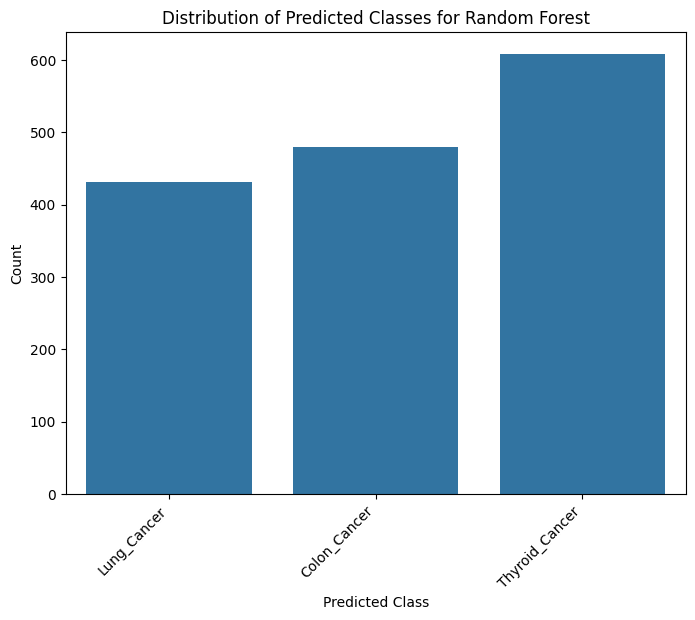

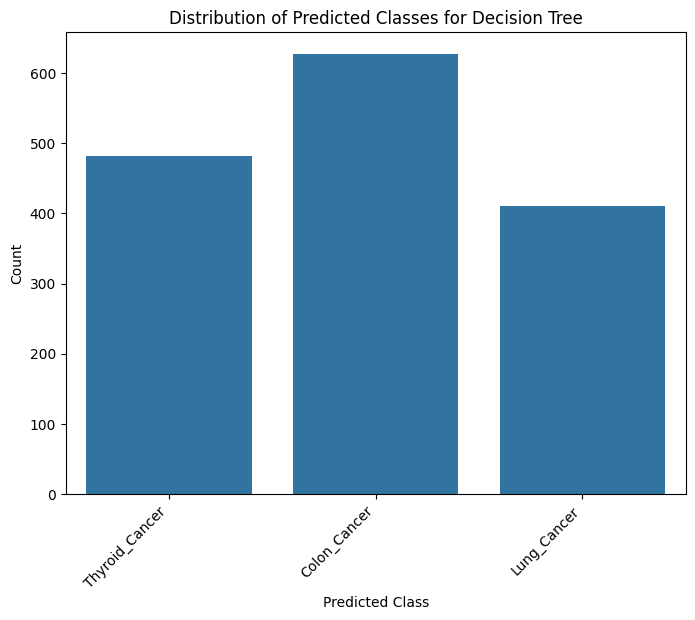

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predicted_class_distribution(predictions, model_name, label_mapping):
    # Mengambil prediksi
    predicted_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

    # Mengubah nilai prediksi menjadi label asli menggunakan label_mapping
    predicted_labels_mapped = [label_mapping[int(pred)] for pred in predicted_labels]

    # Plot hasilnya
    plt.figure(figsize=(8, 6))
    sns.countplot(x=predicted_labels_mapped)
    plt.title(f'Distribution of Predicted Classes for {model_name}')
    plt.xlabel('Predicted Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha="right")  # Rotasi label agar lebih jelas jika terlalu panjang
    plt.show()

# Menggunakan label_mapping dari model yang sudah dilatih
plot_predicted_class_distribution(predictions_lr, "Logistic Regression", label_mapping)
plot_predicted_class_distribution(predictions_rf, "Random Forest", label_mapping)
plot_predicted_class_distribution(predictions_dt, "Decision Tree", label_mapping)